 # RL bitcoin trader

 In this notebook I'll use DQN to trade bincoin. The dataset using kaggle in blow.

 https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [ ]:
# Download the data
# This cell have to exeucate twice in order to save it into path:/kaggle/input/bitcoin-historical-data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset files:", path)

In [1]:
#Import area

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense


# 1.Data cleaning

This data contain all of bitcoin price in history(from 2012). Recorded every 60 secouds. Denoted by Unix time.

Since Bitcoin at begining is basicily nothing changed. Secoud, Global politics is complex, The price will be change by it (eg. Trump 2024 elected).

There're two solutions:
1.  If price totel change during 5 min is not change more then 5 dollar. will denoted by empty. otherwise keep it.

2. If price totel change totel change. price go up more then 30% itself within a week. will be denoted by empty

## Why we need a dataset for DQNAgnet:
The Data contain bitcoin price in history, I treat those pricies as "State" element in environment. which given to agent.

## Mindset of data missed data for RL agent:
After cleaning Data there are alot of slot missed with price. at each episodes i'll randomily choice random area as given sigma(State). $\sum_{t=0}^{k} S_t$

remeber turn df into 2d array.

In [2]:
#df = pd.read_csv('btcusd_1-min_data.csv')
df = pd.read_csv('Cleaned-btcusd_1-min_data.csv')

C:\Users\wu1c\AppData\Local\Temp\ipykernel_13848\321721027.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Cleaned-btcusd_1-min_data.csv')


In [5]:
#Not going to use too early data
df = df[2500000:]

C:\Users\wu1c\AppData\Local\Temp\ipykernel_13848\2834891890.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


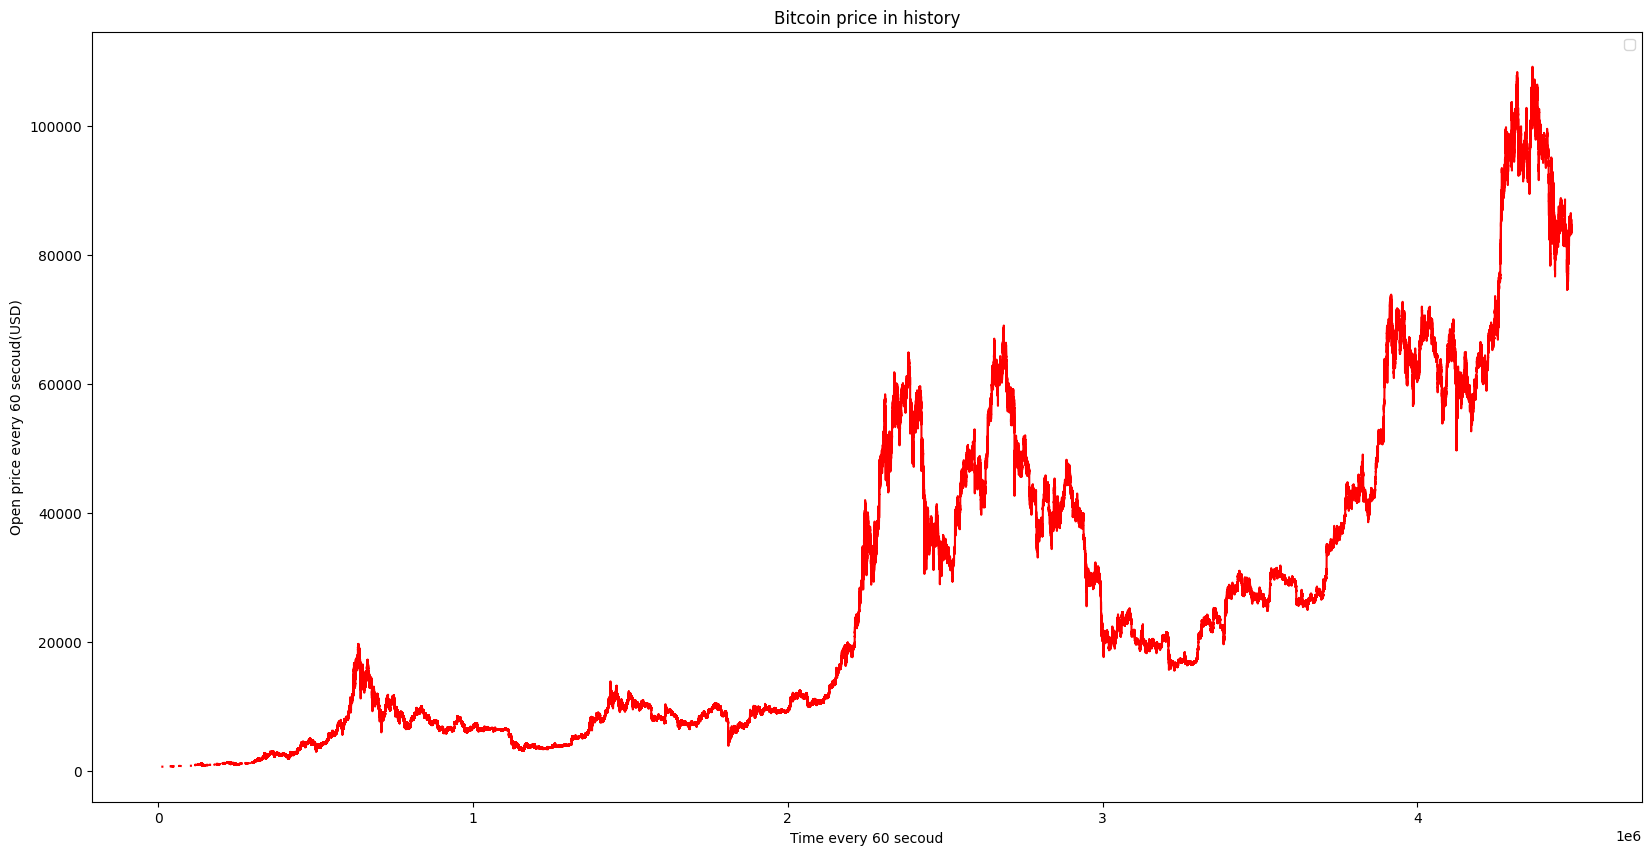

In [6]:
plt.figure(figsize=(20,10))
plt.plot([x for x in range(df['Open'].shape[0])], df['Open'], color = 'red')
plt.title("Bitcoin price in history")
plt.xlabel("Time every 60 secoud")
plt.ylabel("Open price every 60 secoud(USD)")
plt.legend();

In [7]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'datetime'], dtype='object')

In [8]:
df.head(3),
df.tail(3),
df.shape

(4489483, 7)

In [9]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
2500000,1.475412e+09,NaN,609.56,609.56,609.56,0.098469,2016-10-02 12:41:00+00:00
2500001,1.475412e+09,NaN,609.56,609.56,609.56,0.000000,2016-10-02 12:42:00+00:00
2500002,1.475412e+09,NaN,609.55,609.55,609.55,0.025000,2016-10-02 12:43:00+00:00
2500003,1.475412e+09,NaN,611.17,611.17,611.17,0.270000,2016-10-02 12:44:00+00:00
2500004,1.475412e+09,NaN,611.20,611.20,611.20,0.050000,2016-10-02 12:45:00+00:00


In [100]:
#Solution 1

opens = df['Open'].values
to_null = np.zeros(len(opens), dtype=bool)

for i in range(len(opens) - 4):
    price_list = opens[i:i+5]
    if np.max(price_list) - np.min(price_list) < 5:
        to_null[i:i+5] = True

df.loc[to_null, 'Open'] = None


In [101]:
#Solution 2
opens = df['Open'].values
to_null = np.zeros(len(opens), dtype=bool)

for i in range(len(opens) - 4):
  price_list = opens[i:i+5]
  if (np.min(price_list) * 1.3) < np.max(price_list):
    to_null[i:i+5] = True

df.loc[to_null, "Open"] = None

In [103]:
df.to_csv("Cleaned-btcusd_1-min_data.csv", index=False)

## 2. Replaybuffer:

This dict will contain all of agent given action in histroy.
which cause agent learning.

**NOTE that in this project agent isn't learning from the given data(bitcoin data). IS FROM THE REPLAYBUFFER. NOT GIVEN DATA**

each slot contain  
$s_t$,

$s_t+1$,

$a$,

$r$,

$done$
(wthever episode finished or not).

overall this is auto $\pi_t$($a_t$ | $s_t$)

In [ ]:
class Replaybuffer:
    def __init__(self, state_dim, action_size, size):
       self.obs_buf = np.zeros([size, size,state_dim], dtype=np.float32)
       self.obs2_buf = np.zeros([size, size,state_dim], dtype=np.float32)
       self.reward_buf = np.zeros(size, dtype = np.float32)
       self.action_buf = np.zeros(size, dtype = np.uint8)
       self.done_buf = np.zeros(size, dtype = np.uint8)
       self.pointer, self.size, self,max_size = 0,0,size
    def store(self, obs, obs2, reward, action, done):
        self.obs_buf[self.pointer] = obs
        self.obs2_buf[self.pointer] = obs2
        self.reward_buf[self.pointer] = reward
        self.action_buf[self.pointer] = action
        self.done_buf[self.pointer] = done
        self.pointer = (self.pointer+1) % self.max_size
        self.size = min(self.size+1, self.max_size)
    def sample_batch(self, batch_size = 32):
        idx = np.random.randint(0, self.size, batch_size)
        return {self.obs_buf[idx],
            self.obs2_buf[idx],
            self.reward_buf[idx],
            self.action_buf[idx],
            self.done_buf[idx]}

In [15]:
def get_scalar():
    states = []
    for _ in range(env.n_stpe):
        action = np.random.choice([env.action_space])
        state, reward, done, info = env.step(action)
        states.append(state)
        if done: break
    scalar = StandardScaler()
    scalar = scalar.fit(states)
    return scalar

In [16]:
def create_notwork(state_dim, action_dim, hidden_layer = 1, hidden_cell = 32):

    i = Input(shape = (state_dim,))
    x = i
    for _ in range(hidden_layer):
        x = Dense(hidden_cell, activation = "relu")(x)

    x = Dense(action_dim, activation = "softmax")(x)

    model = Model(i,x)

    model.compile(optimizer = "adam", loss = "mse")
    print(model.summary())
    return model

In [19]:
class BitcoinEnv:
    def __init__(self, data, money_buy_each_time, investment_money = 20000, n_stpe = 1200):
        self.bitcoin_in_history = data
        #n_step mean to agent will trade n_step/60 hours
        self.n_stpe = n_stpe
        self.money_buy_each_time = money_buy_each_time

        self.cur_step = None
        self.investment_money = investment_money
        self.bitcoin_wallet = None
        self.bitcoin_price = None
        self.cur_cash = None

        #0 = sell, 1 = hold, 2 = buy
        self.action_space = [[0],[1],[2]]
        self.action_list = np.arange(3)

        #3 type of 1.currily Price, 2.Bitcoin wallet 3.Cash in hand
        self.state_dim = 3

        self.reset()

    def reset(self):
        self.cur_step = 0
        self.bitcoin_wallet = 0
        self.investment_money = self.investment_money
        self.bincoin_price = self.bitcoin_in_history[self.cur_step]

        return self._get_obs()
    
    def step(self, action):
        assert action in self.action_space

        prev_val = self._get_obs()

        self.cur_step += 1
        self.bitcoin_price = self.bitcoin_in_history[self.cur_step]

        self._trade(action)

        cur_val = self._get_val()

        reward = cur_val - prev_val

        done = self.cur_stpe == self.n_step - 1

        info = {"cur_val": cur_val}

        return self._get_obs(), reward, done, info

    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[0] = self.bitcoin_price
        obs[1] = self.bitcoin_wallet
        obs[2] = self.cur_cash

    def _get_val(self):
        return self.bitcoin_wallet.dot(self.bitcoin_price) + self.cur_cash
    
    def _trade(self, action):

        action_vector = self.action_list[action]
        if action_vector == [1]: #hold
            return
        elif action_vector == [2]: #buy
            if self.money_buy_each_time <= self.cur_cash:
                self.bitcoin_wallet += self.money_buy_each_time / self.bitcoin_price
                self.cur_cash -= self.money_buy_each_time
        elif action_vector == [0]: #sell(sell all currently have)
            if self.bitcoin_wallet > 0:
                self.cur_cash += self.bitcoin_wallet * self.bitcoin_price
                self.bitcoin_wallet = 0

In [ ]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = Replaybuffer(state_size)